In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import xarray as xr
import numpy as np

import funnel as fnl

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/pooch/core.py:185: UserWarning: Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.
  warn(message)


In [3]:
import ncar_jobqueue
from dask.distributed import Client
try:
    cluster
    client
except: 
    cluster = ncar_jobqueue.NCARCluster(project='NCGD0011')
    cluster.adapt(minimum_jobs=0, maximum_jobs=24)
    client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.20:33160 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
cmp = fnl.Component(
    model='cesm2',
    experiment='historical',
    variable='POC_FLUX_100m'    
)
cmp

cesm2-historical-ocn-pop.h-POC_FLUX_100m:
  catalog: /glade/u/home/mclong/p/cesm2-marbl/notebooks/funnel/catalogs/campaign-cesm2-cmip6-timeseries.json
  query: {'experiment': 'historical', 'component': 'ocn', 'stream': 'pop.h', 'variable': ['POC_FLUX_100m']}

In [5]:
ds_ts = cmp.get_dataset('timeseries-ann',
                         normalize=False,
                         persist=True,
                         clobber=False).compute()
ds_ts

Dataset(s):   0%|                                        | 0/1 [00:00<?, ?it/s]

making /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-historical-ocn-pop.h-POC_FLUX_100m

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component:experiment:stream'


Dataset(s): 100%|████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-historical-ocn-pop.h-POC_FLUX_100m/timeseries_ann.nc


<xarray.Dataset>
Dimensions:        (d2: 2, member_id: 11, time: 165, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60)
Coordinates:
    dz             (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    dz_150m        (z_t_150m) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
  * z_w_bot        (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * member_id      (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * z_t            (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w            (z_w) float64 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_t_150m       (z_t_150m) float64 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
Dimensions without coordinates: d2
Data variables:
    POC_FLUX_100m  (time, member_id) float64 1.807e+16 1.899e+16 ... 1.883e+16
    time_bound     (time, d2) float64 6.753e+05 6.756e+05 ... 7.355e+05

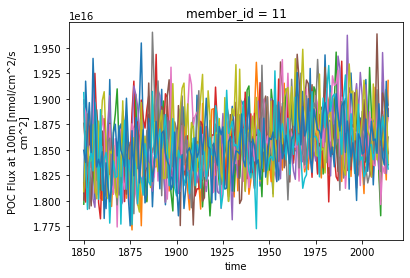

In [6]:
for member_id in ds_ts.member_id.values:
    ds_ts.POC_FLUX_100m.sel(member_id=member_id).plot()

In [7]:
ds_map = cmp.get_dataset('time-mean',
                         time_slice=slice("1990-01-15", "2014-12-31"),
                         persist=True,
                         clobber=False)
ds_map

computing time mean over:
<xarray.DataArray 'time' (time: 300)>
array([cftime.DatetimeNoLeap(1990, 1, 16, 12, 0, 0, 0, 3, 16),
       cftime.DatetimeNoLeap(1990, 2, 15, 0, 0, 0, 0, 5, 46),
       cftime.DatetimeNoLeap(1990, 3, 16, 12, 0, 0, 0, 6, 75), ...,
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, 6, 289),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, 2, 320),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, 4, 350)], dtype=object)
Coordinates:
  * time     (time) object 1990-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:  time
    bounds:     time_bound

writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-historical-ocn-pop.h-POC_FLUX_100m/time_mean.nc


<xarray.Dataset>
Dimensions:        (member_id: 11, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60)
Coordinates:
  * member_id      (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG          (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT           (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG          (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT            (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT            (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06
    DXU            (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU            (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06
    TAREA          (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA          (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT            (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    REGION_MASK    (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * z_t            (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    dz             (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
  * z_w            (z_w) float64 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot        (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * z_t_150m       (z_t_150m) float64 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    dz_150m        (z_t_150m) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
Dimensions without coordinates: nlat, nlon
Data variables:
    POC_FLUX_100m  (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

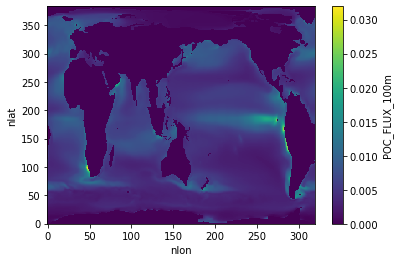

In [8]:
ds_map.POC_FLUX_100m.mean('member_id').plot()